In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# مسیر دیتاست
data_dir = "dataset/"

# تعریف ترنسفورم‌ها (پیش‌پردازش‌ها و augmentation)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomRotation(15),  # چرخش تصادفی تا 15 درجه
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  # برش تصادفی و تغییر اندازه
        transforms.RandomHorizontalFlip(),  # وارونه‌سازی افقی
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # تغییر روشنایی، کنتراست و اشباع
        transforms.ToTensor(),  # تبدیل تصویر به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی به بازه [-1, 1]
    ]),
    "validation": transforms.Compose([
        transforms.Resize((299, 299)),  # تغییر اندازه
        transforms.ToTensor(),  # تبدیل به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),  # تغییر اندازه
        transforms.ToTensor(),  # تبدیل به تنسور
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # نرمال‌سازی
    ])
}

# بارگذاری داده‌ها با استفاده از ImageFolder
image_datasets = {
    "train": datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms["train"]),
    "validation": datasets.ImageFolder(root=f"{data_dir}/validation", transform=data_transforms["validation"]),
    "test": datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms["test"]),
}

# DataLoader برای هر مجموعه داده
dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=32, shuffle=True, num_workers=4),
    "validation": DataLoader(image_datasets["validation"], batch_size=32, shuffle=False, num_workers=4),
    "test": DataLoader(image_datasets["test"], batch_size=32, shuffle=False, num_workers=4),
}

# سایز دیتاست‌ها
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation", "test"]}

# کلاس‌ها
class_names = image_datasets["train"].classes
print(f"Classes: {class_names}")
print(f"Train size: {dataset_sizes['train']}")
print(f"Validation size: {dataset_sizes['validation']}")
print(f"Test size: {dataset_sizes['test']}")

num_aug_per_epoch = len(dataloaders["train"])  # تعداد batchها در هر epoch
effective_dataset_size = 32 * dataset_sizes['train']  # تعداد تصاویر "مجازی" در هر epoch (32 = batch size)

print(f"Effective Train size (with augmentation per epoch): {effective_dataset_size}")


Classes: ['deforest', 'fresh']
Train size: 30
Validation size: 17
Test size: 17
Effective Train size (with augmentation per epoch): 960


In [2]:
import torch
import torch.nn as nn
from torchvision import models

# بارگذاری مدل InceptionV3 با وزن‌های پیش‌آموزش داده شده
# model = models.inception_v3(pretrained=True)
model = models.efficientnet_b0(pretrained=True)


# Freeze کردن تمام لایه‌های پیش‌آموزش داده شده
for param in model.parameters():
    param.requires_grad = True



# # تغییر لایه خروجی (fully connected layer)
# num_ftrs = model.fc.in_features  # تعداد ورودی‌های لایه fully connected
# model.fc = torch.nn.Linear(model.fc.in_features, 2)  # تنظیم برای دو کلاس

# تغییر لایه خروجی (Fully Connected Layer)
num_ftrs = model.classifier[1].in_features  # تعداد ورودی‌های لایه classifier
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 256),  # لایه میانی
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),  # خروجی نهایی برای ۲ کلاس
    nn.Softmax(dim=1)
)

# انتقال مدل به GPU در صورت موجود بودن
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

/Users/realxoman/Programming/PoultryInspector/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/realxoman/Programming/PoultryInspector/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# تعداد epochها و مشخصات دیگر
num_epochs = 30
best_accuracy = 0.0

# تعریف تابع هزینه
class_weights = [1.0, 2.0]  # وزن برای هر کلاس
weights = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# تعریف بهینه‌ساز (فقط لایه‌های جدید باید آپدیت شوند)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Scheduler برای کاهش نرخ یادگیری در صورت عدم پیشرفت
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



# تابع آموزش مدل
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    global best_accuracy  # برای ذخیره بهترین مدل
    
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # هر دو فاز: آموزش و اعتبارسنجی
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # مدل در حالت آموزش
            else:
                model.eval()  # مدل در حالت ارزیابی

            running_loss = 0.0
            running_corrects = 0

            # پردازش داده‌ها
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # صفر کردن گرادیان‌ها
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward Pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward Pass و بهینه‌سازی (فقط در فاز train)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # جمع‌آوری آمار
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # تنظیم scheduler (فقط در فاز train)
            if phase == 'train':
                scheduler.step()

            # محاسبه میانگین Loss و Accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # ذخیره بهترین مدل
            if phase == 'validation' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_efficientnet_model.pth')
                print("Best model saved!")

    print("Training complete")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# شروع آموزش
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

Epoch 1/30
--------------------


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, criterion):
    model.eval()  # حالت ارزیابی
    test_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward Pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # ثبت نتایج
            test_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # ذخیره پیش‌بینی‌ها و برچسب‌ها
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # محاسبه دقت کلی
    test_loss = test_loss / len(dataloader.dataset)
    test_accuracy = running_corrects.double() / len(dataloader.dataset)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # گزارش کامل Precision، Recall، F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes))

    # رسم ماتریس Confusion
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataloader.dataset.classes)
    disp.plot(cmap="Blues")
    plt.show()

# ارزیابی مدل روی داده‌های تست
evaluate_model(model, dataloaders['test'], criterion)

torch.save(model, 'final_efficientnet_model.pth')
torch.save(model.state_dict(), 'final_efficientnet_model_weight.pth')


Epoch 1/30
--------------------
Train Loss: 0.6834 Acc: 0.6667 Recall: 0.6923 Specificity: 0.6471
Validation Loss: 0.6849 Acc: 0.7059 Recall: 1.0000 Specificity: 0.1667
Best model saved!
Epoch 2/30
--------------------
Train Loss: 0.6729 Acc: 0.8667 Recall: 0.8462 Specificity: 0.8824
Validation Loss: 0.6785 Acc: 0.8235 Recall: 1.0000 Specificity: 0.5000
Best model saved!
Epoch 3/30
--------------------
Train Loss: 0.6571 Acc: 0.8000 Recall: 1.0000 Specificity: 0.6471
Validation Loss: 0.6695 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Best model saved!
Epoch 4/30
--------------------
Train Loss: 0.6329 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Validation Loss: 0.6597 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 5/30
--------------------
Train Loss: 0.6103 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Validation Loss: 0.6481 Acc: 1.0000 Recall: 1.0000 Specificity: 1.0000
Epoch 6/30
--------------------
Train Loss: 0.6009 Acc: 0.9667 Recall: 1.0000 Specificity: 0.9412
Val

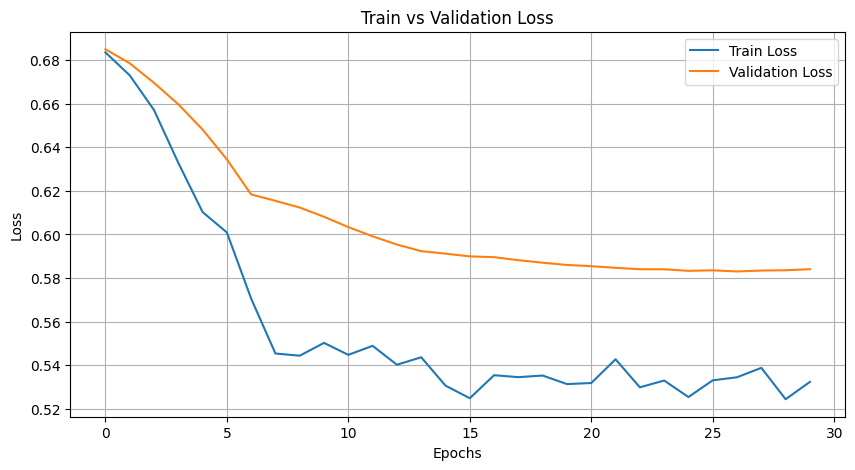

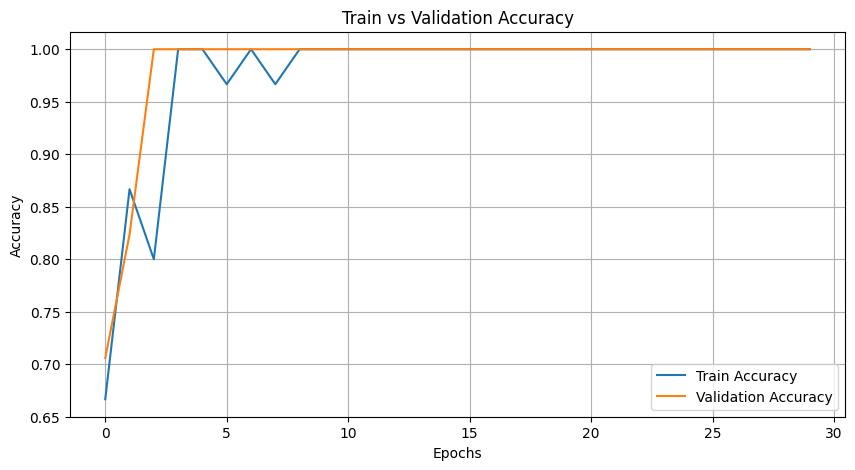

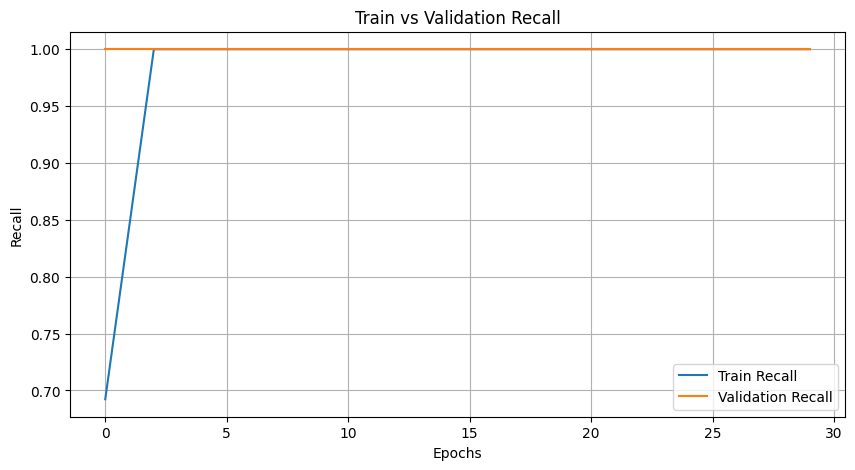

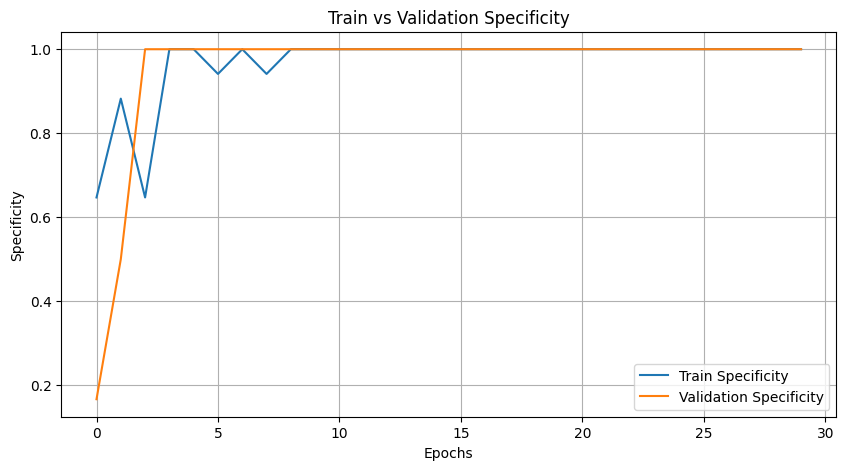

In [5]:
# تعریف تابع برای محاسبه Recall و Specificity
from sklearn.metrics import confusion_matrix

def calculate_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    TN, FP, FN, TP = cm.ravel()

    # محاسبه معیارها
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return recall, specificity

# ذخیره تاریخچه Loss، Accuracy، Recall و Specificity
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
train_recall_history = []
val_recall_history = []
train_specificity_history = []
val_specificity_history = []

# تابع آموزش مدل
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    global best_accuracy  # برای ذخیره بهترین مدل

    best_accuracy = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # هر دو فاز: آموزش و اعتبارسنجی
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # مدل در حالت آموزش
            else:
                model.eval()  # مدل در حالت ارزیابی

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # پردازش داده‌ها
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # صفر کردن گرادیان‌ها
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward Pass
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward Pass و بهینه‌سازی (فقط در فاز train)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # جمع‌آوری آمار
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # ذخیره پیش‌بینی‌ها و برچسب‌ها برای محاسبه Recall و Specificity
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            # تنظیم scheduler (فقط در فاز train)
            if phase == 'train':
                scheduler.step()

            # محاسبه میانگین Loss و Accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # محاسبه Recall و Specificity
            recall, specificity = calculate_metrics(all_labels, all_preds)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Recall: {recall:.4f} Specificity: {specificity:.4f}")

            # ذخیره مقادیر برای رسم نمودارها
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                train_recall_history.append(recall)
                train_specificity_history.append(specificity)
            elif phase == 'validation':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                val_recall_history.append(recall)
                val_specificity_history.append(specificity)

            # ذخیره بهترین مدل
            if phase == 'validation' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_efficientnet_model.pth')
                print("Best model saved!")

    print("Training complete")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# شروع آموزش
train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

# رسم نمودارهای Loss و Accuracy
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(10, 5))
plt.plot(train_recall_history, label='Train Recall')
plt.plot(val_recall_history, label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train vs Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

# Specificity
plt.figure(figsize=(10, 5))
plt.plot(train_specificity_history, label='Train Specificity')
plt.plot(val_specificity_history, label='Validation Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.title('Train vs Validation Specificity')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model = models.efficientnet_b0(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.Softmax(dim=1)
)
model.load_state_dict(torch.load('final_efficientnet_model_weight.pth'))
model = model.to(device)
model.eval()


In [ ]:
model = torch.load('final_efficientnet_model.pth')
model = model.to(device)
model.eval()


In [ ]:
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()


In [ ]:
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.legend()
plt.show()
